## Classifying Medical Text with PyTorch

In this project, we'll explore how to build deep learning models with PyTorch to classify health-related medical text into its correct focus area. We'll use a subset of the [MedQuAD dataset](https://github.com/abachaa/MedQuAD/tree/master) from this [research paper](https://arxiv.org/pdf/1901.08079), which is a real-world dataset containing medical question-answer pairs that have been collected from trusted health sources such as the NIH and MedlinePlus. Each answer is associated with a specific _focus area_ representing the broader medical topic it aims to address. 

In clinical settings, manual labeling of medical information is tedious, time-consuming, and expensive. Therefore, the goal of this project is to build an automated AI system to help medical professionals better categorize and organize vast amounts of medical information quickly and accurately. 

Specifically, this project looks to build two deep learning classifiers:

🧠 **1. Feedforward Neural Network**
- a simple feedforward neural network to serve as a baseline model
- faster and less expensive to train

🤖 **2. Fine-tuned BERT Model**
- a specialized pre-trained PubMedBERT trained on biomedical literature
- leverages attention mechanisms to understand medical text better

**Note:** The models in this project are built and trained on a limited dataset that may not generalize well to the broader population or clinical settings. Therefore, the models are not intended for real-world medical applications and should not be relied upon for diagnosing, predicting, or managing any health outcomes. Any health-related decisions should always be made with the guidance of a qualified healthcare professional!

#### MedQuAD Dataset Column Summary

- **question**: A question related to a specific medical topic typically asked by patients.
- **answer**: An accurate response to the question sourced from trusted health organizations.
- **source**: The official source that provided the question-answer pair.
- **focus_area**: The broader, overarching medical top the question-answer pair belongs to.

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import torch
torch.manual_seed(42)

from transformers import logging
logging.set_verbosity_error()

import seaborn as sns
sns.set(style='whitegrid', palette='Paired')

import matplotlib.pyplot as plt
%matplotlib inline

#### Load and Inspect Data

In [2]:
medquad_df = pd.read_csv("datasets/medquad.csv")
medquad_df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [3]:
medquad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB


It looks like there are 16,412 question-answer pairs (rows), but there are some questions with answers missing. There are also a couple of pairs missing their focus area.

#### Data Exploration and Visualization

Next, let's explore and visualize the data!

**Focus Areas**

In [4]:
# Count the number of unique focus areas
medquad_df['focus_area'].nunique()

5126

Looks like there are 5,126 unique focus areas. Let's take a look at the most commonly occurring focus areas.

In [5]:
# Counts of the top 25 most common focus areas
medquad_df['focus_area'].value_counts()[:25]

focus_area
Breast Cancer                       53
Prostate Cancer                     43
Stroke                              35
Skin Cancer                         34
Alzheimer's Disease                 30
Colorectal Cancer                   29
Lung Cancer                         29
Causes of Diabetes                  28
Heart Failure                       28
High Blood Cholesterol              28
Heart Attack                        28
High Blood Pressure                 27
Parkinson's Disease                 25
Leukemia                            22
Shingles                            21
Osteoporosis                        21
Age-related Macular Degeneration    20
Diabetes                            20
Hemochromatosis                     20
Diabetic Retinopathy                19
Psoriasis                           19
Gum (Periodontal) Disease           19
Kidney Disease                      17
Dry Mouth                           16
Balance Problems                    16
Name: count, d

**Focus Groups**

Instead of trying to classify 5,126 unique classes, let's group the top 25 most common focus areas into **5** broader categories (focus groups):
- Cancers
- Cardiovascular diseases
- Metabolic and endocrine disorders
- Neurological and cognitive disorders
- Other age-related and immune disorders

In [6]:
# Group the top 25 most common focus areas into 5 broader categories (focus groups)
focus_area_map = {
    'Cancers': ['Breast Cancer', 'Prostate Cancer', 'Skin Cancer', 
                'Colorectal Cancer', 'Lung Cancer', 'Leukemia'],
    
    'Cardiovascular Diseases': ['Stroke', 'Heart Failure', 'Heart Attack',
                                'High Blood Cholesterol', 'High Blood Pressure'],
    
    'Metabolic & Endocrine Disorders': ['Causes of Diabetes', 'Diabetes', 'Diabetic Retinopathy',
                                        'Hemochromatosis', 'Kidney Disease'],
    
    'Neurological & Cognitive Disorders': ['Alzheimer\'s Disease', 'Parkinson\'s Disease', 'Balance Problems'],
    
    'Other Age-Related & Immune Disorders': ['Shingles', 'Osteoporosis', 'Age-related Macular Degeneration',
                                             'Psoriasis', 'Gum (Periodontal) Disease', 'Dry Mouth']
}

# Create reverse mapping
condition_to_focus_area = {
    condition: focus_area
    for focus_area, conditions in focus_area_map.items()
    for condition in conditions
}

# Create new column `focus_group` containing focus group
medquad_df['focus_group'] = medquad_df['focus_area'].map(condition_to_focus_area)

# Verify the number of unique focus groups
n_focus_groups = medquad_df['focus_group'].nunique()
print("Number of unique focus groups:", n_focus_groups)

Number of unique focus groups: 5


When we created the new column `focus_group`, it returned `nan` values for rows without a focus group (corresponding to rows whose focus area was not in the top 25 most occurring). 

We'll use `.dropna()` to drop the rows with `nan` values.

In [7]:
# Drops missing values including those without a focus group
print("Shape before dropping:", medquad_df.shape)
medquad_df = medquad_df.dropna()
print("Shape after dropping:", medquad_df.shape)

Shape before dropping: (16412, 5)
Shape after dropping: (647, 5)


Let's visualize the counts within each focus group.

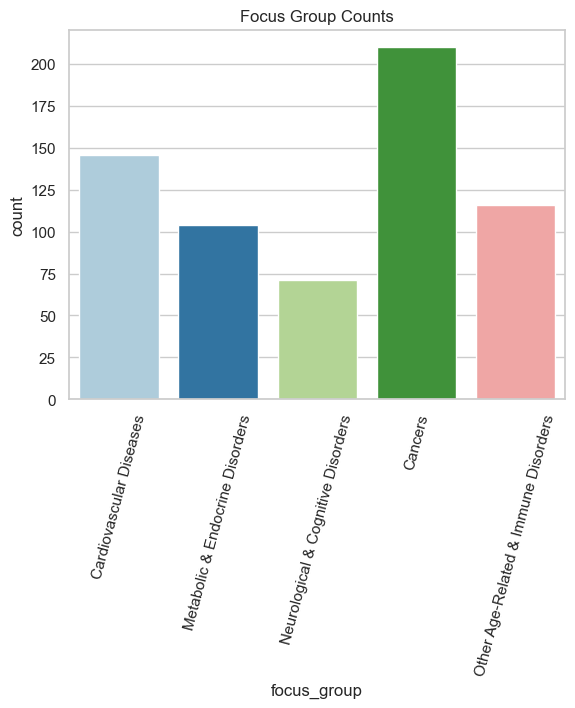

focus_group
Cancers                                 210
Cardiovascular Diseases                 146
Other Age-Related & Immune Disorders    116
Metabolic & Endocrine Disorders         104
Neurological & Cognitive Disorders       71
Name: count, dtype: int64
focus_group
Cancers                                 0.324575
Cardiovascular Diseases                 0.225657
Other Age-Related & Immune Disorders    0.179289
Metabolic & Endocrine Disorders         0.160742
Neurological & Cognitive Disorders      0.109737
Name: proportion, dtype: float64


In [8]:
# Plot focus group counts
sns.countplot(x='focus_group', data=medquad_df)
plt.title('Focus Group Counts')
plt.xticks(rotation=75)
plt.show()

print(medquad_df['focus_group'].value_counts(0))
print(medquad_df['focus_group'].value_counts(1))

**Answer Training Text**

Let's calculate descriptive statistics for the text lengths in the `answer` column, which will serve as the training texts.

In [9]:
# Character lengths
medquad_df['answer_char_length'] = medquad_df['answer'].astype(str).apply(len)
# Word lengths
medquad_df['answer_word_count'] = medquad_df['answer'].astype(str).apply(lambda x: len(x.split()))

# Calculate descriptive statistics
answer_length_stats = medquad_df[['answer_char_length', 'answer_word_count']].describe()
answer_length_stats

,answer_char_length,answer_word_count
count,647.000000,647.000000
mean,2084.395672,330.584235
std,2736.381687,418.234941
min,87.000000,10.000000
25%,458.500000,75.000000
50%,1066.000000,171.000000
75%,2598.000000,423.500000
max,29046.000000,4281.000000


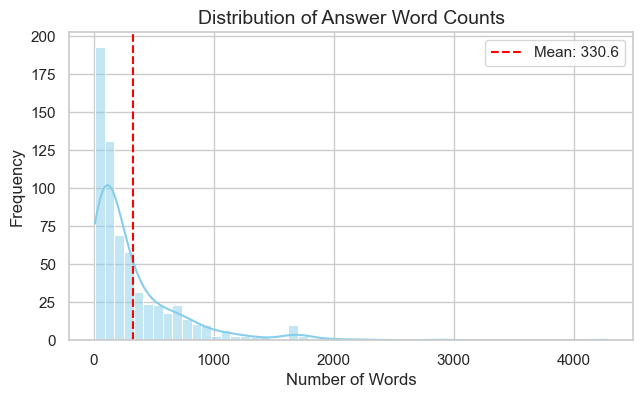

In [10]:
# Visualize the distribution of word counts
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.histplot(medquad_df['answer_word_count'], kde=True, color='skyblue')
plt.title('Distribution of Answer Word Counts', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=answer_length_stats['answer_word_count']['mean'], 
            color='red', linestyle='--', label=f"Mean: {answer_length_stats['answer_word_count']['mean']:.1f}")
plt.legend()
plt.show()

Looking at the descriptive statistics for the word counts in the `answer` texts, we see that:
- the mean word count is 330.6 words
- the median word count is 171.0 words (which is notably different than the mean)
- the shortest text is 10 words
- the longest text is 4,281 words

We might consider dropping texts with notably low or high word counts (outliers).

#### Text Cleaning and Pre-Processing

Next, we'll need to clean and pre-process the texts in the `answer` column and the target labels in the `focus_group` column.

**Encode Target Focus Groups**

In [11]:
focus_map = {"Neurological & Cognitive Disorders":0,
             "Cancers":1,
             "Cardiovascular Diseases":2,
             "Metabolic & Endocrine Disorders":3,
             "Other Age-Related & Immune Disorders":4}

medquad_df['focus_group'] = medquad_df['focus_group'].replace(focus_map)

**Drop Duplicate Rows**

We've noticed that many of the text in the `answer` column are duplicates (or fairly similar), which is common among medical texts.

We'll need to drop duplicates, otherwise:
- the model will overfit to over-represented texts
- the model will have more trouble generalizing to unseen texts
- model training will take longer 

In [12]:
# Returns all rows that are duplicates of a previous row
print("Shape before duplicates:", medquad_df.shape)
duplicates = medquad_df[medquad_df.duplicated(subset='answer')]
medquad_df = medquad_df.drop_duplicates(subset='answer')
print("Shape after removing duplicates:", medquad_df.shape)

Shape before duplicates: (647, 7)
Shape after removing duplicates: (624, 7)


**Split the Data into Training and Testing Sets**

Let's split the dataset into 80% training and 20% testing.

Since our dataset is fairly small (considering that we only used the top 25 most occurring focus areas), we'll need to stratify the distribution of focus groups to ensure fair representation in the training and testing sets.

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(medquad_df,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=medquad_df['focus_group'])

In [14]:
print("Training set distribution:", train_df['focus_group'].value_counts(1))
print("Testing set distribution:", test_df['focus_group'].value_counts(1))

Training set distribution: focus_group
1    0.334669
2    0.234469
4    0.186373
3    0.130261
0    0.114228
Name: proportion, dtype: float64
Testing set distribution: focus_group
1    0.336
2    0.232
4    0.184
3    0.136
0    0.112
Name: proportion, dtype: float64


**Create Training Corpus**

Next, let's create the training corpus by converting each text sequence and focus group labels to lists:

- `train_texts` will contain each answer text separated by commas
- `train_labels` will contain each focus group label separated by commas

In [15]:
train_texts = train_df['answer'].tolist()
train_labels = train_df['focus_group'].tolist()

# Print the first two training texts and labels
print(train_texts[0:2])
print(train_labels[0:2])

["Diabetic retinopathy often has no early warning signs. Don't wait for symptoms. Be sure to have a comprehensive dilated eye exam at least once a year.  Learn more about a comprehensive dilated eye exam.", 'Breast cancer affects one in eight women during their lives. Breast cancer kills more women in the United States than any cancer except lung cancer. No one knows why some women get breast cancer, but there are a number of risk factors. Risks that you cannot change include       - Age - the chance of getting breast cancer rises as a woman gets older     - Genes - there are two genes, BRCA1 and BRCA2, that greatly increase the risk. Women who have family members with breast or ovarian cancer may wish to be tested.     - Personal factors - beginning periods before age 12 or going through menopause after age 55       Other risks include being overweight, using hormone replacement therapy (also called menopausal hormone therapy), taking birth control pills, drinking alcohol, not having 

**Remove Keywords from Training Text**

One issue we might encounter is that the training text might contain the actual focus group label, which may cause data leakage. Our model could cheat by detecting keywords and memorizing the focus group label instead of actually learning the patterns and relationships within the medical text.

One strategy is to remove keywords from the training text:

In [16]:
import re

remove_keywords = [
    'Breast Cancer', 'Prostate Cancer', 'Skin Cancer',
    'Colorectal Cancer', 'Lung Cancer', 'Leukemia', 'Stroke', 'Heart Failure', 'Heart Attack',
    'High Blood Cholesterol', 'High Blood Pressure', 'Causes of Diabetes', 'Diabetes', 'Diabetic Retinopathy',
    'Hemochromatosis', 'Kidney Disease', 'Alzheimer\'s Disease', 'Parkinson\'s Disease', 'Balance Problems',
    'Shingles', 'Osteoporosis', 'Age-related Macular Degeneration',
    'Psoriasis', 'Gum (Periodontal) Disease', 'Dry Mouth'
]

# Split all multi-word phrases into individual words 
# Ex. "High Blood Cholesterol" ==> "High", "Blood", "Cholesterol"
words_to_remove = set()
for phrase in remove_keywords:
    for word in re.findall(r'\b\w+\b', phrase):
        words_to_remove.add(word.lower())  # lowercased for case-insensitive match

# Create regex pattern to match any of the words
pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, words_to_remove)) + r')\b', flags=re.IGNORECASE)

# Remove individual words from each text
masked_train_texts = [pattern.sub('', text) for text in train_texts]

# Normalize whitespace
masked_train_texts = [re.sub(r'\s+', ' ', text).strip() for text in masked_train_texts]

**Tokenize the Training Text**

Next, we'll tokenize each training text into word tokens.

In [17]:
import re
def tokenize(text):
    tokenized_text = re.findall(r'\b\w+\b', text.lower())
    return tokenized_text

tokenized_training_corpus = [tokenize(focus_area_text) for focus_area_text in masked_train_texts]

# Print the first tokenized text sequence
print(tokenized_training_corpus[0])

['often', 'has', 'no', 'early', 'warning', 'signs', 'don', 't', 'wait', 'for', 'symptoms', 'be', 'sure', 'to', 'have', 'a', 'comprehensive', 'dilated', 'eye', 'exam', 'at', 'least', 'once', 'a', 'year', 'learn', 'more', 'about', 'a', 'comprehensive', 'dilated', 'eye', 'exam']


**Count the Number of Occurrences for each Word Token**

In [18]:
from collections import Counter
combined_training_corpus = []
for text in tokenized_training_corpus:
    for token in text:
        combined_training_corpus.append(token)

word_freqs = Counter(combined_training_corpus)

**Create the Vocabulary**

We'll build the vocabulary using the top 1,000 most commonly occuring word tokens.

In [19]:
MAX_VOCAB_SIZE = 1000
most_common_words = word_freqs.most_common(MAX_VOCAB_SIZE)
print("Top 10 Most Common Words: ", most_common_words[0:10])

Top 10 Most Common Words:  [('the', 7750), ('to', 3886), ('and', 3786), ('a', 3469), ('in', 2694), ('or', 2666), ('is', 2301), ('are', 1643), ('for', 1537), ('your', 1523)]


Then, we'll create the vocabulary as a dictionary assigning each token a token ID based on its positional value and frequency counts. 

We'll also create two special tokens:
- `<unk>` with the token ID value `0`
- `<pad>` with the token ID value `1`

In [20]:
vocab = {word: idx + 2 for idx, (word, freq) in enumerate(most_common_words)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1 

len(vocab)

1002

**Encode and Pad/Truncate the Tokenized Text**

Using the vocabulary, we'll encode the text.

While encoding the text, we'll also pad or truncate the text to a specified maximum sequence length value of **128** tokens.

In [21]:
def encode_text(text, vocab):
    tokenized_text = tokenize(text)
    encoded_text = [vocab.get(word, vocab['<unk>']) for word in tokenized_text]
    return encoded_text

def pad_or_truncate(encoded_text, max_len):
    if len(encoded_text) > max_len:
        return encoded_text[:max_len]
    else:
        return encoded_text + [vocab['<pad>']] * (max_len - len(encoded_text)) 

In [22]:
MAX_SEQ_LENGTH = 128
padded_train_seqs = [pad_or_truncate(encode_text(seq, vocab), max_len=MAX_SEQ_LENGTH) for seq in train_texts]

**Convert to PyTorch Tensors**

Next, we'll convert the encoded, tokenized text into PyTorch tensors for training.

We'll also organize the training tensors into training batches.

In [23]:
import torch
X_train_tensor = torch.tensor(padded_train_seqs)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long)

from torch.utils.data import DataLoader, TensorDataset
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#### Simple Neural Network

The first text classification model we'll build is a simple neural network with an embedding layer that will serve as a baseline model. 

**Build NN Architecture**

In [24]:
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(42) # set random seed --do not change!

class SimpleNNWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SimpleNNWithEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.fc1 = nn.Linear(embed_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

**Instantiate the Model**

In [25]:
vocab_size = len(vocab)
embed_size = 50 
hidden_size = 100
output_size = n_focus_groups

nn_classifier = SimpleNNWithEmbedding(vocab_size, embed_size, hidden_size, output_size)
print(nn_classifier)

SimpleNNWithEmbedding(
  (embedding): Embedding(1002, 50)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)


**Specify Loss Function and Optimizer**

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_classifier.parameters(), lr=0.0001)

**Model Training**

In [27]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if (epoch + 1) % 100 == 0:
            print(f"[Epoch {epoch + 1}/{num_epochs}], Average CE Loss: {avg_loss:.10f}")

# Train the model
train_model(nn_classifier, train_dataloader, criterion, optimizer, num_epochs=500)

[Epoch 100/500], Average CE Loss: 1.1501948610
[Epoch 200/500], Average CE Loss: 0.6930906149
[Epoch 300/500], Average CE Loss: 0.3697187589
[Epoch 400/500], Average CE Loss: 0.1885060179
[Epoch 500/500], Average CE Loss: 0.0910679052


**Model Evaluation**

Next, we'll evaluate the simple neural network on the testing set.

**Pre-Process the Testing Set**

In [28]:
# Convert the testing texts and labels to lists
test_texts = test_df['answer'].tolist()
test_labels = test_df['focus_group'].tolist()

# Encode and pad/truncate the testing sequences
padded_test_seqs = [pad_or_truncate(encode_text(seq, vocab), MAX_SEQ_LENGTH) for seq in test_texts]

# Convert testing sequences to tensors
X_tensor_test = torch.tensor(padded_test_seqs)
y_tensor_test = torch.tensor(test_labels, dtype=torch.long)

# Batch the testing set
from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

**Generate Testing Set Predictions**

In [29]:
import torch.nn.functional as F

def get_predictions_and_probabilities(model, test_loader):
    model.eval()

    all_probs = [] 
    all_labels = []

    with torch.no_grad(): 
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            probs = F.softmax(outputs, dim=1)  
            all_probs.extend(probs.cpu().numpy())
            predicted_labels = torch.argmax(outputs, dim=1)
            all_labels.extend(predicted_labels.cpu().numpy())

    return all_probs, all_labels

# Generate predictions
nn_pred_probs, nn_pred_labels = get_predictions_and_probabilities(nn_classifier, test_loader)

**Evaluate the Neural Network**

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

focus_group_names = ["Neurological & Cognitive Disorders", "Cancers", "Cardiovascular Diseases", 
                     "Metabolic & Endocrine Disorders", "Other Age-Related & Immune Disorders"]

conf_matrix = confusion_matrix(test_labels, nn_pred_labels)
report = classification_report(test_labels, nn_pred_labels, target_names=focus_group_names)

print(conf_matrix)
print(report)

[[12  1  0  1  0]
 [ 0 41  0  0  1]
 [ 1  3 22  2  1]
 [ 0  0  5  9  3]
 [ 0  1  2  0 20]]
                                      precision    recall  f1-score   support

  Neurological & Cognitive Disorders       0.92      0.86      0.89        14
                             Cancers       0.89      0.98      0.93        42
             Cardiovascular Diseases       0.76      0.76      0.76        29
     Metabolic & Endocrine Disorders       0.75      0.53      0.62        17
Other Age-Related & Immune Disorders       0.80      0.87      0.83        23

                            accuracy                           0.83       125
                           macro avg       0.82      0.80      0.81       125
                        weighted avg       0.83      0.83      0.83       125



Nice, the simple neural network looks fairly decent, with an overall accuracy of 83%! 

Let's quickly review each classification metric:
- **Precision:** Based on all of the predictions made for a specific focus group, how many of the predictions did the model get correct?
- **Recall:** Based on all of the texts belonging to a specific focus group, how many did the model identify?
- **F1-score:** The harmonic mean of precision and recall.

Now, let's break down the performance for each class:
- **Neurological & Cognitive Disorders:** high precision (few false positives) and good recall (identifies most texts). 
- **Cancers:** high precision (few false positives) and excellent recall (identifies 98% of cancer texts)
- **Cardiovascular Diseases:** decent and balanced f1-score, but needs improvement in both precision and recall
- **Metabolic & Endocrine Disorders:** decent precision (fair amount of false positives) but weak recall (failed to identify almost half of the focus group texts)
- **Other Age-Related & Immune Disorders:** decent precision and strong recall

Overall, the simple neural network does a decent job of classifying medical texts into the five focus groups, but there are definitely areas for improvement. For example, the worst-performing class, "Metabolic & Endocrine Disorders," is also the most underrepresented class. We could improve performance by upsampling or adding more related texts to the training set.

#### Fine-Tune a BERT Transformer

Let's now train a more advanced BERT transformer!

We'll use a specialized BERT called [BiomedBERT](https://huggingface.co/microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext) from HuggingFace that has been pre-trained on medical texts like abstracts and full articles from PubMed.

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load BiomedBERT model and tokenizer
model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_focus_groups)

In [32]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
bert_model = bert_model.to(device)

Using device: cuda


**Freeze and Unfreeze Layers**

Next, we'll freeze and unfreeze specific layers in the BiomedBERT:

1. Initial freezing of all layers
2. Unfreeze the classification head
3. Unfreeze the last 3 transformer layers
4. Unfreeze the pooler layer

In [33]:
# Freeze all parameters first
for param in bert_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in bert_model.classifier.parameters():
    param.requires_grad = True

# Unfreeze the last 3 layers of the encoder (layers 9-11)
for i in range(9, 12):
    for param in bert_model.bert.encoder.layer[i].parameters():
        param.requires_grad = True

# Unfreeze the pooler (connecting the BERT output to the classification head)
for param in bert_model.bert.pooler.parameters():
    param.requires_grad = True

**Pre-Process the Training Text for BiomedBERT**

1. Set a maximum sequence length of 512 tokens (standard for BiomedBERT)
2. Tokenize the training texts
3. Convert the training texts and labels into tensors
4. Load the training data into batches

Note: We'll use the same masked training set (with the focus group labels removed from the `answer` texts) to train the simple neural network.

In [34]:
MAX_SEQ_LENGTH = 512

X_train = bert_tokenizer(masked_train_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH)
y_train = torch.tensor(train_labels, dtype=torch.long)

from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(
    X_train['input_ids'].to(device), 
    X_train['attention_mask'].to(device), 
    y_train.to(device)
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

**Specify Loss Function and Optimizer**

In [35]:
import torch.nn as nn
import torch.optim as optim

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, bert_model.parameters()), 
                              lr=0.00001)
criterion = nn.CrossEntropyLoss()

**Fine-Tuning Loop**

In [36]:
num_epochs = 10
for epoch in range(num_epochs):
    bert_model.train()
    total_loss = 0.0
    
    for batch_X, batch_attention_mask, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = bert_model(input_ids=batch_X, 
                                     attention_mask=batch_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, batch_y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}, Average CE Loss: {avg_loss}')

Epoch 1, Loss: 1.5464492812752724
Epoch 2, Loss: 1.4472644589841366
Epoch 3, Loss: 1.2931099757552147
Epoch 4, Loss: 0.9881765721365809
Epoch 5, Loss: 0.6530503612011671
Epoch 6, Loss: 0.4282114403322339
Epoch 7, Loss: 0.30224315030500293
Epoch 8, Loss: 0.21683162776753306
Epoch 9, Loss: 0.17268079495988786
Epoch 10, Loss: 0.131569865741767


**Model Evaluation**

Lastly, let's evaluate the fine-tuned BiomedBERT and compare its performance against the simple neural network baseline.

**Pre-Process the Testing Set**

In [37]:
# Tokenize and convert to tensors
X_test = bert_tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH)
y_test = torch.tensor(test_labels, dtype=torch.long)

# Batch the testing set
from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(X_test['input_ids'].to(device), 
                             X_test['attention_mask'].to(device),
                             y_test.to(device))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

**Generate Testing Set Predictions**

In [38]:
import torch.nn.functional as F

bert_model.eval()
bert_pred_probs = []
bert_pred_labels = []

with torch.no_grad():
    for batch_X, batch_attention_mask, batch_y in test_loader:
        outputs = bert_model(input_ids= batch_X, 
                                   attention_mask= batch_attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        bert_pred_probs.extend(probs.cpu().numpy())
        
        predicted_labels = torch.argmax(logits, dim=1)
        bert_pred_labels.extend(predicted_labels.cpu().numpy())

**Evaluate the Fine-Tuned BiomedBERT**

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

focus_group_names = ["Neurological & Cognitive Disorders", "Cancers", "Cardiovascular Diseases", 
                     "Metabolic & Endocrine Disorders", "Other Age-Related & Immune Disorders"]

confusion_matrix = confusion_matrix(test_labels, bert_pred_labels)
report = classification_report(test_labels, bert_pred_labels, target_names=focus_group_names)

print(confusion_matrix)
print(report)

[[14  0  0  0  0]
 [ 0 41  0  0  1]
 [ 0  0 29  0  0]
 [ 0  0  1 16  0]
 [ 0  0  0  0 23]]
                                      precision    recall  f1-score   support

  Neurological & Cognitive Disorders       1.00      1.00      1.00        14
                             Cancers       1.00      0.98      0.99        42
             Cardiovascular Diseases       0.97      1.00      0.98        29
     Metabolic & Endocrine Disorders       1.00      0.94      0.97        17
Other Age-Related & Immune Disorders       0.96      1.00      0.98        23

                            accuracy                           0.98       125
                           macro avg       0.98      0.98      0.98       125
                        weighted avg       0.98      0.98      0.98       125



Amazingly, the fine-tuned specialized BiomedBERT significantly outperforms the simple neural network, achieving nearly perfect classification scores across all classes in each key metric! 

Now, let's break down the performance for each class:
- **Neurological & Cognitive Disorders:** perfectly classified the text into this focus group
- **Cancers:** perfect precision, near perfect recall
- **Cardiovascular Diseases:** near perfect precision, perfect recall
- **Metabolic & Endocrine Disorders:** perfect precision, high recall score (remember, the simple neural network had a recall score of 53% for this under-represented class!)
- **Other Age-Related & Immune Disorders:** high precision, perfect recall

The specialized BiomedBERT does a near-perfect job of classifying medical texts into the five focus groups. There are many things to consider as to why BiomedBERT performs much better than the simple neural network:
- BiomedBERT is pre-trained on biomedical literature from PubMed and already has a strong foundational understanding of medical terminology and context
- BiomedBERT has a much more complex architecture with attention mechanisms that allow it to better capture meaningful patterns and relationships within the training text

The specialized BiomedBERT is the superior model for our medical text classification task!

#### Example Prediction

Let's build a quick function that classifies an example text using the fine-tuned BiomedBERT.

In [51]:
def biomedbert_classify_text(text):
    """
    Function that classifies a medical text (str) into 5 focus groups: 
        - "Neurological & Cognitive Disorders" 
        - "Cancers" 
        - "Cardiovascular Diseases"
        - "Metabolic & Endocrine Disorders" 
        - "Other Age-Related & Immune Disorders"
    """
    # Pre-Process and Tokenize the Text
    MAX_SEQ_LENGTH = 512
    tokenized_text = bert_tokenizer(
        example_text,
        padding='max_length',
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        return_tensors="pt"
    )
    
    # Move tokenized text to device
    tokenized_text = {k: v.to(device) for k, v in tokenized_text.items()}
    
    # Generate prediction
    with torch.no_grad(): 
        outputs = bert_model(
            input_ids=tokenized_text['input_ids'],
            attention_mask=tokenized_text['attention_mask']
        )
        predicted_label = torch.argmax(outputs.logits, dim=1)

    # Encode predicted output (int) to focus group label (str)
    reverse_focus_map = {0:"Neurological & Cognitive Disorders",
                         1:"Cancers",
                         2:"Cardiovascular Diseases",
                         3:"Metabolic & Endocrine Disorders",
                         4:"Other Age-Related & Immune Disorders"
                }
    predicted_focus = reverse_focus_map[predicted_label.cpu().item()]
    return predicted_focus

**Classify Example Text**

In [52]:
example_text = '''The patient displays progressive deterioration of cognitive abilities affecting memory, thinking, language, and judgment. Family members report personality changes and difficulty with daily activities. 
Imaging studies show cortical atrophy and enlarged ventricles. Laboratory tests rule out vitamin deficiencies, thyroid disorders, and other reversible causes of cognitive decline. 
Treatment focuses on symptom management and maintaining quality of life through cholinesterase inhibitors and environmental modifications.'''

biomedbert_classify_text(example_text)

'Neurological & Cognitive Disorders'

#### Conclusion

In conclusion, our project successfully developed neural networks to classify health-related medical text into focus area groups. Specifically, fine-tuning a specialized BiomedBERT offers a near-perfect solution for this classification task. This demonstrates the potential for machine learning as a viable tool to assist medical professionals in the tedious and time-consuming task of labeling medical information.

Future work could explore using different model architectures, dataset balancing techniques, collecting more data, and applying more rigorous testing/validation strategies. Remember, these models are not intended for real-world medical applications and should not be relied upon for diagnosing, predicting, or managing diabetes or any other health outcomes. Any health-related decisions should always be made with the guidance of a qualified healthcare professional! 